In [5]:
import scipy.special as sps
import pyro 
import pyro.distributions as dist
import torch
from torch.distributions import constraints
from pyro.infer import MCMC, NUTS
from scipy.stats import norm
from torch import nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.nn import PyroModule
from pyro import optim
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroSample
from pyro.infer import Predictive


pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

import sys 
sys.path.append('../../python/')

import os

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
import statsmodels

import HNSCC_analysis_pipeline_lib as lib

import pickle as pkl
import seaborn as sbn

print(pyro.__version__)
assert pyro.__version__.startswith('1.1.0')

import time

%matplotlib notebook

1.1.0


# Hill-Langmuir Bayesian Regression 

# Bayesian Hill Model Regression 

We'll use the Hill model for simplicity: 

$$ F(c, E_{max}, E_0, EC_{50}, H) = E_0 + \frac{E_{max} - E_0}{1 + (\frac{EC_{50}}{C})^H} $$

We're also going to do this in a bayesian context to incorporate priors and model uncertainty in parameter fitting. 

## Parameter effects 

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fsrep14701/MediaObjects/41598_2015_Article_BFsrep14701_Fig1_HTML.jpg?as=webp)

1. Di Veroli GY, Fornari C, Goldlust I, Mills G, Koh SB, Bramhall JL, et al. An automated fitting procedure and software for dose-response curves with multiphasic features. Scientific Reports. 2015 Oct 1;5(1):1–11. 


## choosing priors 


Shift, should be centered around zero 

$$ E_0 \propto N(0, \sigma_{E_0}) $$ 


between 0 and 1

$$ E_{max} \propto Beta(a_{E_{max}}, b_{E_{max}}) $$ 

$$ mean = \frac{a}{a+b} $$


Hill coefficient, should be a positive integer.

$$ H \propto Poisson(\lambda_H) $$ 

$$ \lambda \propto gamma(\alpha_{\lambda}, \beta_{\lambda}) $$

$$ Mean = \lambda = E[gamma] = \frac{ \alpha_{\lambda} }{\beta_{\lambda}} $$ 


EC50, positive 

$$ EC50 \propto gamma(\alpha_{EC50}, \beta_{EC50}) $$ 


In [11]:
class plotter: 
    def __init__(self, params, figsize=(20,10), subplots = (2,7)): 
        '''
        '''
        assert len(params) <= subplots[0]*subplots[1], 'wrong number of subplots for given params to report'
        self.fig, self.axes = plt.subplots(*subplots,figsize=figsize, sharex='col', sharey='row')
        self.vals = {p:[] for p in params}
        self.params = params
        
    def record(self):
        '''
        '''
        for p in self.params: 
            self.vals[p].append(pyro.param(p).item())
    
    def plot_all(self): 
        '''
        '''
        for p, ax in zip(self.params, self.axes.flat): 
            ax.plot(self.vals[p], 'b-')
            ax.set_title(p, fontsize=25)
            ax.set_xlabel('step', fontsize=20)
            ax.set_ylabel('param value', fontsize=20)
            
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)
        plt.show()
        
def model(X, Y=None):
    '''
    
    '''
    E0 = pyro.sample('E0', dist.Normal(0., E0_std))
    #E0 = 0
    
    Emax = pyro.sample('Emax', dist.Beta(a_emax, b_emax))
    
    _lambda = pyro.sample('_lambda', dist.Gamma(alpha_lambda, beta_lambda))
    H = pyro.sample('H', dist.Poisson(_lambda))
    
    EC50 = pyro.sample('EC50', dist.Gamma(alpha_ec50, beta_ec50))

    obs_sigma = pyro.sample("obs_sigma", dist.Gamma(a_obs, b_obs))
    obs_mean = E0 + (Emax - E0)/(1+(EC50/X)**H)
    
    with pyro.plate("data", X.shape[0]):
        obs = pyro.sample("obs", dist.Normal(obs_mean, obs_sigma), obs=Y)
        
    return obs_mean

def guide(X, Y=None):
    
    _E0_mean = pyro.param('E0_mean', torch.tensor(0.))
    _E0_std = pyro.param('E0_std', torch.tensor(E0_std), constraint=constraints.positive)
    E0 = pyro.sample('E0', dist.Normal(_E0_mean, _E0_std))
    #E0 = 0
    
    _a_emax = pyro.param('_a_emax', torch.tensor(a_emax), constraint=constraints.positive)
    _b_emax = pyro.param('_b_emax', torch.tensor(b_emax), constraint=constraints.positive)
    Emax = pyro.sample('Emax', dist.Beta(_a_emax, _b_emax))
    
    _alpha_lambda = pyro.param('_alpha_lambda', torch.tensor(alpha_lambda), constraint=constraints.positive)
    _beta_lambda = pyro.param('_beta_lambda', torch.tensor(beta_lambda), constraint=constraints.positive)
    _lambda = pyro.sample('_lambda', dist.Gamma(_alpha_lambda, _beta_lambda))
    H = pyro.sample('H', dist.Poisson(_lambda))
    
    _alpha_ec50 = pyro.param('_alpha_ec50', torch.tensor(alpha_ec50), constraint=constraints.positive)
    _beta_ec50 = pyro.param('_beta_ec50', torch.tensor(beta_ec50), constraint=constraints.positive)
    EC50 = EC50 = pyro.sample('EC50', dist.Gamma(_alpha_ec50, _beta_ec50))
    
    _a_obs = pyro.param('_a_obs', torch.tensor(a_obs), constraint=constraints.positive)
    _b_obs = pyro.param('_b_obs', torch.tensor(b_obs), constraint=constraints.positive)
    obs_sigma = pyro.sample("obs_sigma", dist.Gamma(_a_obs, _b_obs))
    
    obs_mean = E0 + (Emax - E0)/(1+(EC50/X)**H)
    
    return obs_mean

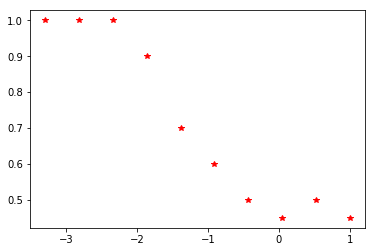

ValueError: The parameter concentration has invalid values
Trace Shapes:  
 Param Sites:  
      E0_mean  
       E0_std  
      _a_emax  
      _b_emax  
_alpha_lambda  
 _beta_lambda  
  _alpha_ec50  
   _beta_ec50  
Sample Sites:  
      E0 dist |
        value |
    Emax dist |
        value |
 _lambda dist |
        value |
       H dist |
        value |

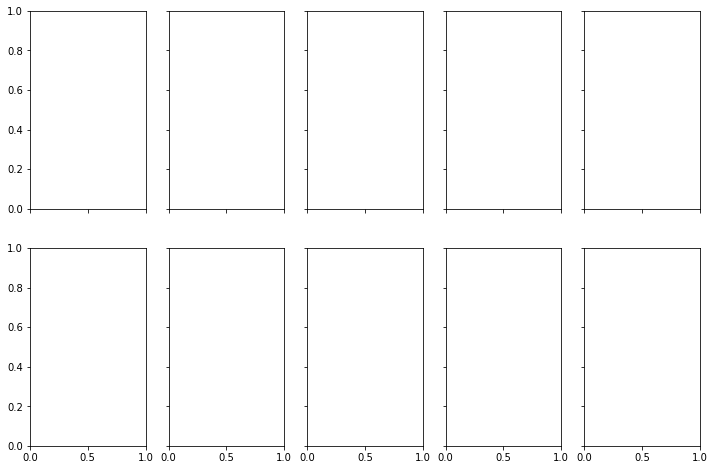

In [12]:
%matplotlib inline 

############ PRIORS ###############
E0_std = 0.25

# uniform
a_emax = 1.
b_emax = 1.

# lambda 
alpha_lambda = 5. 
beta_lambda = 5. 

#EC50
alpha_ec50 = 1.
beta_ec50 = 1. 

# obs error 
a_obs = 1
b_obs = 3
###################################


Y = torch.tensor([1., 1., 1., 0.9, 0.7, 0.6, 0.5, 0.45, 0.5, 0.45], dtype=torch.float)
X = torch.tensor([np.log10(10./3**i) for i in range(10)][::-1], dtype=torch.float)

plt.figure()
plt.plot(X,Y, 'r*')
plt.show()

adam = optim.Adam({"lr": 1e-1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

tic = time.time()
STEPS = 25000
pyro.clear_param_store() #  '_alpha_lambda', '_beta_lambda',
myplotter = plotter(['_a_emax', '_b_emax', '_a_obs', '_b_obs', '_alpha_ec50', '_beta_ec50'], figsize=(12, 8), subplots=(2,5))
_losses = []
last=0
loss = 0
n = 500
for j in range(STEPS):
    loss += svi.step(X, Y) 
    myplotter.record()
    if j % n == 0:
        print(f"[iteration {j}] loss: {(loss / n) :.2f} [change={(loss/n - last/n):.2f}]", end='\t\t\t\r')
        _losses.append(np.log10(loss))
        last = loss
        loss = 0
        
myplotter.plot_all()

plt.figure()
plt.plot(_losses)
plt.show()

toc = time.time()
print(f'time to train {STEPS} iterations: {toc-tic:.2g}s')

In [ ]:
x_data = torch.tensor(np.log10(np.logspace(-5, 3, 200)))

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))

samples = predictive(x_data)
pred_summary = summary(samples)

y_mean = pred_summary['obs']['mean'].detach().numpy()
y_5 = pred_summary['obs']['5%'].detach().numpy()
y_95 = pred_summary['obs']['95%'].detach().numpy()

plt.figure()
plt.plot(X,Y, 'k*', label='data')
plt.plot(x_data, y_mean, 'r-')
plt.plot(x_data, y_5, 'g-', label='95% CI')
plt.plot(x_data, y_95, 'g-')

plt.ylim(0,1.2)

plt.legend()
plt.show()


## Try with MCMC

https://forum.pyro.ai/t/need-help-with-very-simple-model/600

In [ ]:
torch.manual_seed(99999)
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1).run(X,Y)

In [ ]:
posterior = pyro.infer.EmpiricalMarginal(mcmc_run, '')
posterior.mean